In [320]:
import pandas as pd
import numpy as np
#data = pd.read_csv('data/Compressed Mortality, 2016.txt', sep=" ", header=None)
#data.columns = ["a", "b", "c", "etc."]
#data = pd.read_fwf('data/Compressed Mortality, 2016.txt')


from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
% matplotlib inline

import glob
import os
import math

from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection


In [321]:
# Compressed Mortality

# get a list of the data files the direction
onlyfiles = [f for f in listdir('data/Compressed Mortality/') if isfile(join('data/Compressed Mortality/', f))]
print(onlyfiles)

# for each txt file...
for i in np.arange(len(onlyfiles)):

    data_temp = pd.read_table('data/Compressed Mortality/' + onlyfiles[i], header='infer', index_col=None,  names=('Notes', 'County', 'County Code', 'Deaths', 'Population', 'Crude Rate'))
    #data_temp.drop(data_temp.index[0])
    data_dropped = data_temp.iloc[1:] #Remove the first row because it's the files's header
    data_dropped['County Code'] = pd.to_numeric(data_dropped['County Code']) # Make the zipcode a float instead of a string
    #print(data_dropped.head(5))

    data_dropped.insert(0, 'year', int(onlyfiles[i][-8:-4])) # Add the year as a column
#print(data.head)
    if i == 0:
        data = data_dropped
    else:
        data = pd.concat([data, data_dropped]) # add each year's text file to the overall dataframe


data_sorted = data.sort_values(by=['County Code', 'year']) # put in order

#print(data_sorted.head(5))

data_mortality = data_sorted


data_mortality.set_index(['County Code', 'year'], inplace=True, drop =False)


temp = np.zeros((data_mortality.shape[0],1))
unreliable = np.zeros((data_mortality.shape[0],1))
for i in range(data_mortality.shape[0]):
    
    
    #print(data['Crude Rate'].iloc[i])
    #s = re.findall('\d*\.?\d+', data['Crude Rate'].iloc[i])
    try:
        temp[i] = float(data_mortality['Crude Rate'].iloc[i].split()[0])
        unreliable[i] = 1
    except:
        temp[i] = float(data_mortality['Crude Rate'].iloc[i])
        unreliable[i] = 0
        
data_mortality['Crude Rate'] =temp


['Compressed Mortality, 1999.txt', 'Compressed Mortality, 2000.txt', 'Compressed Mortality, 2001.txt', 'Compressed Mortality, 2002.txt', 'Compressed Mortality, 2003.txt', 'Compressed Mortality, 2004.txt', 'Compressed Mortality, 2005.txt', 'Compressed Mortality, 2006.txt', 'Compressed Mortality, 2007.txt', 'Compressed Mortality, 2008.txt', 'Compressed Mortality, 2009.txt', 'Compressed Mortality, 2010.txt', 'Compressed Mortality, 2011.txt', 'Compressed Mortality, 2012.txt', 'Compressed Mortality, 2013.txt', 'Compressed Mortality, 2014.txt', 'Compressed Mortality, 2015.txt', 'Compressed Mortality, 2016.txt']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [322]:
# perscrption drugs

# Get all the relevant csv files
onlyfiles = [f for f in listdir('data/Prescriptions/') if isfile(join('data/Prescriptions/', f))]

print(onlyfiles)

# For all the files...
for i in np.arange(len(onlyfiles)):
    # load the CSV
    data_temp = pd.read_csv('data/Prescriptions/' + onlyfiles[i], index_col=None,  names=('State', 'County Code', 'Opioid Perscription Rate'))
    
    # Insert the year as a column in the dataframe
    data_temp.insert(0, 'year', int(onlyfiles[i][-8:-4]))
#print(data.head)
    if i == 0:
        data = data_temp
    else:
        data = pd.concat([data, data_temp]) # Add to the overall dataframe


data_sorted = data.sort_values(by=['County Code', 'year'])


data_perscriptions = data_sorted

data_perscriptions.set_index(['County Code', 'year'], inplace=True, drop =False)

['rxrate_2006.csv', 'rxrate_2007.csv', 'rxrate_2008.csv', 'rxrate_2009.csv', 'rxrate_2010.csv', 'rxrate_2011.csv', 'rxrate_2012.csv', 'rxrate_2013.csv', 'rxrate_2014.csv', 'rxrate_2015.csv', 'rxrate_2016.csv']


In [323]:
# county health statistics

def create_fips_code(df):
    fips_code = []
    for i in range(df['statecode'].shape[0]):
        # combine the statecode and countycode to create the fips_code
        string = '{:d}{:03d}'.format(df['statecode'].iloc[i], df['countycode'].iloc[i])
        fips_code.append(int(string)) 
    return fips_code

# load all data into a single dataframe
data_dir = 'data/county health rankings'
file_wildcard = os.path.join(data_dir, '*.csv')
for i, filepath in enumerate(reversed(glob.glob(file_wildcard))):
    year = filepath.split('/')[-1].split('\\')[-1].split(' ')[0]
    print(i, filepath, year)
    
    # load the data
    data = pd.read_csv(filepath)
    # convert all columns to lower case
    data.columns = map(str.lower, data.columns)
    # calculate the fips_code and insert as 1st column
    data.insert(loc=0, column='County Code', value=create_fips_code(data))
    # insert the year as the 2nd column
    data.insert(loc=1, column='year', value=int(year))
    #
    if i == 0:
        df = data
        orig_columns = data.columns
    else:
        df = pd.concat([df, data])
    print(data.shape)
    
print(df.shape)

data_health_statistics = df
#data_health_statistics.rename(columns = {'5-digit fips code':'County Code'}, inplace = True)


data_health_statistics = data_health_statistics.sort_values(by=['County Code', 'year'])

data_health_statistics.set_index(['County Code', 'year'], inplace=True, drop =False)

0 data/county health rankings\2017 CHR analytic data.csv 2017
(3186, 358)
1 data/county health rankings\2016 CHR analytic data.csv 2016
(3191, 356)
2 data/county health rankings\2015 CHR analytic data.csv 2015
(3191, 331)
3 data/county health rankings\2014 CHR analytic data.csv 2014
(3191, 326)
(12759, 373)


In [324]:
# combine the three dataframes

data_temp = data_mortality.join(data_perscriptions, how ='outer', lsuffix = '_data_mortality', rsuffix = '_data_perscriptions')

data = data_temp.join(data_health_statistics, how = 'outer', lsuffix = '_data', rsuffix = '_data_health_statistics')

data.head(15)


year_data_mortality Notes County  \
County Code year                                     
1000        2014                  NaN   NaN    NaN   
            2015                  NaN   NaN    NaN   
            2016                  NaN   NaN    NaN   
            2017                  NaN   NaN    NaN   
1001        2006                  NaN   NaN    NaN   
            2007                  NaN   NaN    NaN   
            2008                  NaN   NaN    NaN   
            2009                  NaN   NaN    NaN   
            2010                  NaN   NaN    NaN   
            2011                  NaN   NaN    NaN   
            2012                  NaN   NaN    NaN   
            2013                  NaN   NaN    NaN   
            2014                  NaN   NaN    NaN   
            2015                  NaN   NaN    NaN   
            2016                  NaN   NaN    NaN   

                  County Code_data_mortality Deaths Population  Crude Rate  \
County Code year                                                             
1000        2014                         NaN    NaN        NaN         NaN   
            2015                         NaN    NaN        NaN         NaN   
            2016                         NaN    NaN        NaN         NaN   
            2017                         NaN    NaN        NaN         NaN   
1001        2006                         NaN    NaN        NaN         NaN   
            2007                         NaN    NaN        NaN         NaN   
            2008                         NaN    NaN        NaN         NaN   
            2009                         NaN    NaN        NaN         NaN   
            2010                         NaN    NaN        NaN         NaN   
            2011                         NaN    NaN        NaN         NaN   
            2012                         NaN    NaN        NaN         NaN   
            2013                         NaN    NaN        NaN         NaN   
            2014                         NaN    NaN        NaN         NaN   
            2015                         NaN    NaN        NaN         NaN   
            2016                         NaN    NaN        NaN         NaN   

                  year_data_perscriptions State  \
County Code year                                  
1000        2014                      NaN   NaN   
            2015                      NaN   NaN   
            2016                      NaN   NaN   
            2017                      NaN   NaN   
1001        2006                   2006.0    AL   
            2007                   2007.0    AL   
            2008                   2008.0    AL   
            2009                   2009.0    AL   
            2010                   2010.0    AL   
            2011                   2011.0    AL   
            2012                   2012.0    AL   
            2013                   2013.0    AL   
            2014                   2014.0    AL   
            2015                   2015.0    AL   
            2016                   2016.0    AL   

                  County Code_data_perscriptions   ...    \
County Code year                                   ...     
1000        2014                             NaN   ...     
            2015                             NaN   ...     
            2016                             NaN   ...     
            2017                             NaN   ...     
1001        2006                          1001.0   ...     
            2007                          1001.0   ...     
            2008                          1001.0   ...     
            2009                          1001.0   ...     
            2010                          1001.0   ...     
            2011                          1001.0   ...     
            2012                          1001.0   ...     
            2013                          1001.0   ...     
            2014                          1001.0   ...     
    

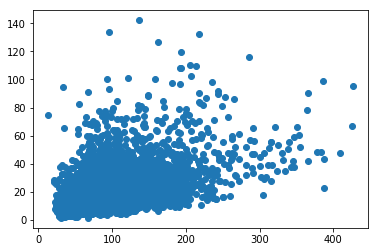

In [325]:
plt.figure()
plt.scatter(data['Opioid Perscription Rate'], data['Crude Rate'])


In [326]:
# remove rows with no response variable

print(data.shape)

null_dataframe = data.isnull()
reduced_data = data.drop(data[null_dataframe["Crude Rate"]].index, inplace=False)

#reduced_data = data.drop(data[(data['Crude Rate'] == 'nan').values].index, inplace=False)

print(reduced_data.shape)




(41002, 384)
(11798, 384)


In [304]:



#print(data.shape)##

#null_dataframe = data.isnull()
#reduced_data = data.drop(data[null_dataframe['drug overdose deaths value']].index, inplace=False)

#reduced_data = data.drop(data[(data['Crude Rate'] == 'nan').values].index, inplace=False)

#print(reduced_data.shape)





In [327]:

#remove useless features

to_remove = ['county that was not ranked', 'drug overdose deaths: modeled upper confidence interval', 'county', 'state', 'drug overdose deaths value', 'Notes','County','County Code_data_mortality','Deaths','Population','State','County Code_data_perscriptions','5-digit fips code','County Code','drug overdose deaths lower confidence interval','drug overdose deaths numerator','drug overdose deaths upper confidence interval','drug overdose deaths: modeled denominator','drug overdose deaths: modeled lower confidence interval','drug overdose deaths: modeled value']

for i in np.arange(len(to_remove)):
    reduced_data.drop(to_remove[i], axis=1, inplace = True)


In [319]:

# changed the code but need the dataframe to be named features
features = reduced_data



(11798, 364)
(11798, 364)


In [328]:

# Make the weird entires in the this features more normal
drinking_water = features['drinking water violations value'].values
drinking_water[drinking_water == 'Yes'] = 1.0
drinking_water[drinking_water == 'No'] = 0.0
drinking_water[drinking_water == '.'] = 0.0

features['drinking water violations value'] = pd.to_numeric(features['drinking water violations value'])



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [329]:
# change ratios like 1:2000 into a decimal in a few variables
features.select_dtypes(include=['O'])
object_variables = ['dentists ratio', 'mental health providers ratio', 'other primary care providers ratio', 'primary care physicians ratio']

for z in np.arange(len(object_variables)):

    mh = features[object_variables[z]].values

    for i in np.arange(features.shape[0]):
        try:
            a = mh[i].find(':')
    #        print(float(mh[i][:a]))
    #        print(1.0/float(mh[i][:a]))

            mh[i] = 1.0/float(mh[i][:a])
    #        print(mh[i])
        except:
            mh[i] = mh[i]

    features[object_variables[z]] = pd.to_numeric(mh)





In [330]:
#features.select_dtypes(include=['O'])
# should be none at this point


In [331]:
# remove rows from years before 2014
print(features.shape)

years = features.index.get_level_values('year')

small_years = years < 2014.0
features_recent = features.drop(features[small_years].index, inplace=False)

print(features_recent.shape)

#test = data.drop(features['year'] < 2014.0,   inplace=False)



(11798, 364)
(2702, 364)


In [332]:
# drop columns that are all nan
features_recent.dropna(axis=1, how='all', thresh=None, subset=None, inplace=True)

# fill nans
features_recent2 = features_recent.apply(lambda x: x.fillna(x.median()),axis=0)

# remove the response variable from the data
response = features_recent2['Crude Rate']
features_final = features_recent2.drop('Crude Rate', axis=1, inplace = False)




In [333]:
# separate the data into a train and dev set
trainX, devX, trainY, devY = model_selection.train_test_split(features_final, response, test_size=0.1, random_state=94305)


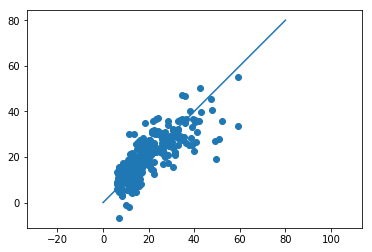

In [334]:
# fit linear regression 
# DATA NEEDS TO BE NORMALIZED
lreg = linear_model.LinearRegression()
lreg.fit(trainX, trainY)

pred = lreg.predict(devX)

mse = np.mean((pred - devY)**2)

lreg.score(devX,devY)

plt.figure()
plt.scatter(devY.values, pred)
plt.axis('equal')
plt.plot([0, 80], [0, 80])
#print(lreg.coef_)


['alcohol-impaired driving deaths lower confidence interval'
 'alcohol-impaired driving deaths value'
 'children in single-parent households lower confidence interval'
 'drinking water violations numerator'
 'inadequate social support lower confidence interval'
 'income inequality lower confidence interval'
 'limited access to healthy foods value'
 'long commute - driving alone lower confidence interval'
 'mental health providers ratio' 'mental health providers value'
 'percent of population that is american indian or alaskan native'
 'percent of population that is female'
 'uninsured adults upper confidence interval' 'uninsured adults value'
 'uninsured upper confidence interval' 'uninsured value'
 'violent crime value']


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid va

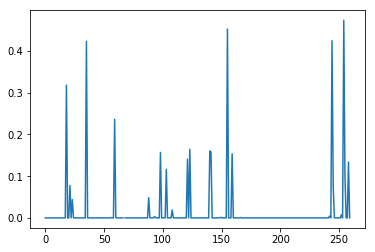

In [339]:
# test for significant variables
F, pval = feature_selection.f_regression(trainX, trainY, center=True)


plt.figure()

plt.plot(pval)


feature_names = features_final.columns.values
index_array = (pval > 0.05)
print(feature_names[index_array])